## Machine Learning Mutli-variate Analysis for Weather Forecast

In [48]:
%matplotlib inline

# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
df = pd.read_csv('/kaggle/input/hanoi-weather-data/hanoi 2015-01-01 to 2025-07-03.csv')
# Convert datetime column to proper format
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

In [7]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [9]:
# initialize a list to store test results
test_ar = []

In [10]:
# Accuracy metrics
def accuracy_metrics(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    print('Mean Absolute Percent Error ', mape, 'Mean Absolute Error', mae, 'Root Mean Square Error (rmse) ' , rmse)
    return mape, mae, rmse

In [11]:
# Display feature names
features = df.columns
print("Features:", features)

# Display dataset shape
print("Dataset Shape:", df.shape)

# Scale the dataset between 0.1 and 1.1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1.1))
df_scaled = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))  # Scale only numerical data

# Convert back to DataFrame for easier handling
df_scaled = pd.DataFrame(df_scaled, columns=df.select_dtypes(include=['float64', 'int64']).columns, index=df.index)
df_scaled

Features: Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')
Dataset Shape: (3719, 33)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
0,0.574777,0.319124,0.475439,0.459551,0.342820,0.414904,0.475817,0.574601,0.100000,0.1,...,0.238004,0.323889,0.800651,0.104,0.457664,0.710201,0.712903,0.8,NaN,0.467347
1,0.515430,0.303187,0.426316,0.414607,0.332376,0.381250,0.475817,0.599274,0.100000,0.1,...,0.257113,0.381389,0.785466,0.381,0.501460,0.679907,0.680645,0.8,NaN,0.497959
2,0.485757,0.386853,0.450877,0.392135,0.387206,0.398077,0.573856,0.741509,0.100000,0.1,...,0.238004,0.370000,0.726898,0.509,0.362774,0.457032,0.454839,0.5,NaN,0.538776
3,0.524332,0.538247,0.531579,0.421348,0.486423,0.453365,0.694771,0.837300,0.101811,1.1,...,0.318684,0.372500,0.585900,0.980,0.391971,0.298764,0.300717,0.4,NaN,0.569388
4,0.545104,0.601992,0.570175,0.437079,0.528198,0.479808,0.769935,0.930189,0.100000,0.1,...,0.238004,0.338333,0.536009,1.000,0.231387,0.389645,0.383154,0.5,NaN,0.610204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,0.663798,0.729482,0.689474,0.576404,0.611749,0.566346,0.884314,0.944702,0.100625,1.1,...,0.295329,0.416389,0.479610,1.067,0.413869,0.652705,0.651971,0.8,0.100000,0.212245
3715,0.723145,0.769323,0.728070,0.637079,0.637859,0.602404,0.890850,0.885196,0.100015,1.1,...,0.397240,0.445556,0.447072,1.002,0.413869,0.692272,0.691398,0.9,0.152632,0.253061
3716,0.693472,0.701594,0.703509,0.607865,0.593473,0.578365,0.861438,0.867779,0.104830,1.1,...,0.435456,0.418056,0.486117,1.065,0.340876,0.252705,0.250538,0.3,0.152632,0.283673
3717,0.456083,0.462550,0.461404,0.369663,0.436815,0.405288,0.501961,0.573149,0.106340,1.1,...,0.550106,0.261111,0.703037,1.100,0.742336,0.169243,0.168100,0.2,0.152632,0.355102


In [36]:
possible_temp_names = [col for col in df.columns if "temp" in col.lower()]
if possible_temp_names:
    target_variable = possible_temp_names[2]  
    print(f"Using '{target_variable}' as the target variable.")
else:
    raise ValueError("Error: No temperature-related column found in dataset.")


Using 'temp' as the target variable.


In [37]:
# Remove non-numeric columns before computing correlation
df_numeric = df.select_dtypes(include=['number'])

In [38]:
# Compute correlation matrix using only numerical data
correlation_matrix = df_numeric.corr()

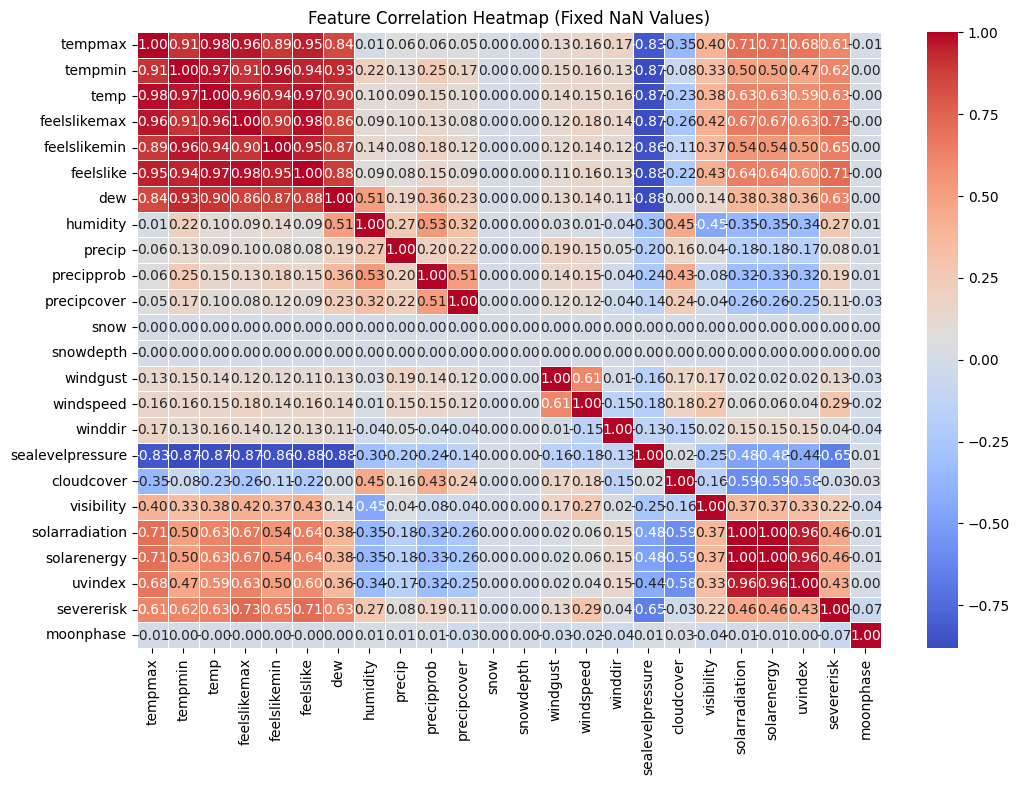

In [39]:
# Replace NaN values with 0 in the correlation matrix
correlation_matrix = correlation_matrix.fillna(0)

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Fixed NaN Values)")
plt.show()

In [40]:
# Selecting highly correlated features (absolute correlation > 0.85)
correlation_threshold = 0.85
to_remove = set()
for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and abs(correlation_matrix.loc[idx, col]) > correlation_threshold:
            to_remove.add(idx)

In [41]:
# Keep only independent features
selected_features = [col for col in df_numeric.columns if col not in to_remove]

# Display selected features
print("Selected Features for ML Models:", selected_features)


Selected Features for ML Models: ['humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'cloudcover', 'visibility', 'severerisk', 'moonphase']


In [42]:
# Scale the dataset
scaler = MinMaxScaler(feature_range=(0.1, 1.1))
df_scaled = scaler.fit_transform(df_numeric[selected_features + [target_variable]])  # Include target variable

In [43]:
df_scaled = pd.DataFrame(df_scaled, columns=selected_features + [target_variable], index=df.index)


In [50]:
df_scaled_filled = df_scaled.fillna(df_scaled.mean())


In [55]:
X = df_scaled_filled[selected_features]
y = df_scaled_filled[[target_variable]]  # Target variable (temperature)

In [56]:
test_ratio = 0.2  # 20% for testing
test_size = int(len(X) * test_ratio)
training_size = len(X) - test_size

x_train = X.iloc[:training_size]
x_test = X.iloc[training_size:]
y_train = y.iloc[:training_size]
y_test = y.iloc[training_size:]

In [57]:
def evaluate_model(model, model_name):
    model.fit(x_train, y_train)  # Train the model
    y_pred = model.predict(x_test)  # Make predictions
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {"Model": model_name, "MAE": mae, "RMSE": rmse}

In [58]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=0),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=0),
    "SVR": SVR(kernel='rbf', C=100, epsilon=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5, weights='distance'),
    "LinearRegression": LinearRegression(fit_intercept=False)
}

results = []
for name, model in models.items():
    results.append(evaluate_model(model, name))

In [64]:
results_df = pd.DataFrame(results)
results_df


,Model,MAE,RMSE
0,RandomForest,0.087426,0.115067
1,GradientBoosting,0.090549,0.120407
2,SVR,0.124965,0.158553
3,KNN,0.096045,0.125534
4,LinearRegression,0.102549,0.127338


In [65]:
# Generate predictions for each model
predictions = {}
for name, model in models.items():
    y_pred = model.predict(x_test)  # Get model predictions
    predictions[name] = y_pred.flatten()  # Flatten predictions for visualization

In [66]:
# Convert actual and predicted values into a DataFrame
comparison_df = pd.DataFrame({
    "Actual": y_test.values.flatten(),
    "RandomForest": predictions["RandomForest"],
    "GradientBoosting": predictions["GradientBoosting"],
    "SVR": predictions["SVR"],
    "KNN": predictions["KNN"],
    "LinearRegression": predictions["LinearRegression"],
}, index=y_test.index)

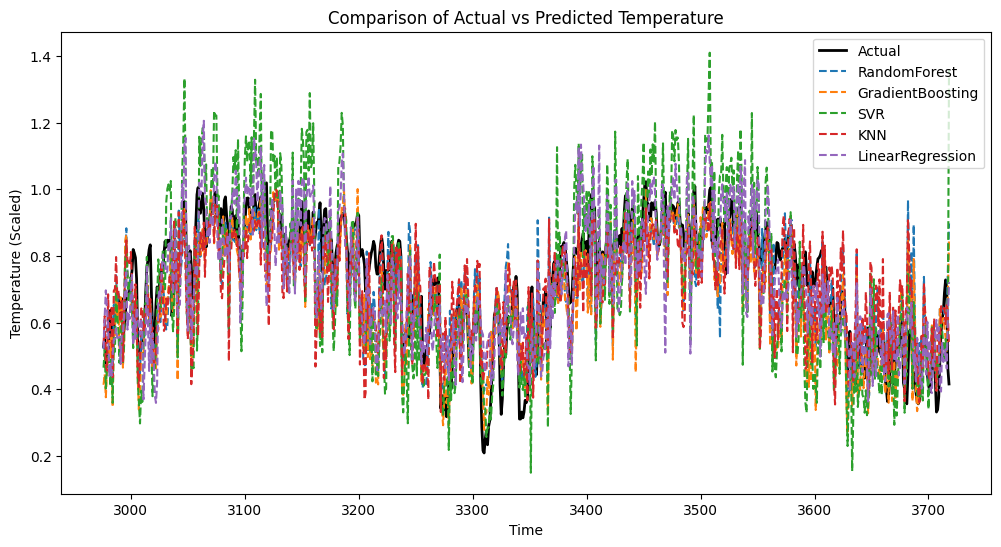

In [67]:
# Plot actual vs predicted temperature for different models
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df["Actual"], label="Actual", color="black", linewidth=2)
plt.plot(comparison_df.index, comparison_df["RandomForest"], label="RandomForest", linestyle="dashed")
plt.plot(comparison_df.index, comparison_df["GradientBoosting"], label="GradientBoosting", linestyle="dashed")
plt.plot(comparison_df.index, comparison_df["SVR"], label="SVR", linestyle="dashed")
plt.plot(comparison_df.index, comparison_df["KNN"], label="KNN", linestyle="dashed")
plt.plot(comparison_df.index, comparison_df["LinearRegression"], label="LinearRegression", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Temperature (Scaled)")
plt.title("Comparison of Actual vs Predicted Temperature")
plt.legend()
plt.show()

In [68]:
comparison_df

,Actual,RandomForest,GradientBoosting,SVR,KNN,LinearRegression
2976,0.528070,0.521004,0.413200,0.464669,0.532015,0.522317
2977,0.549123,0.568456,0.445356,0.518679,0.619553,0.617841
2978,0.478947,0.561726,0.375822,0.402261,0.471775,0.696683
2979,0.489474,0.564758,0.448540,0.465324,0.456117,0.639001
2980,0.524561,0.633509,0.526992,0.498739,0.684815,0.582831
...,...,...,...,...,...,...
3714,0.689474,0.618807,0.585862,0.479529,0.643265,0.497412
3715,0.728070,0.622316,0.554057,0.550434,0.595275,0.519495
3716,0.703509,0.621670,0.512361,0.517271,0.652052,0.462044
3717,0.461404,0.764547,0.685022,0.574118,0.621623,0.622876


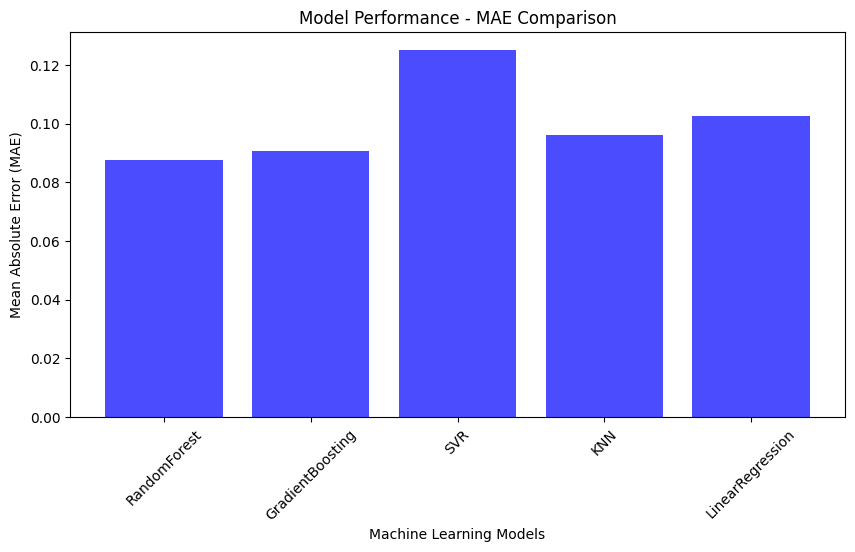

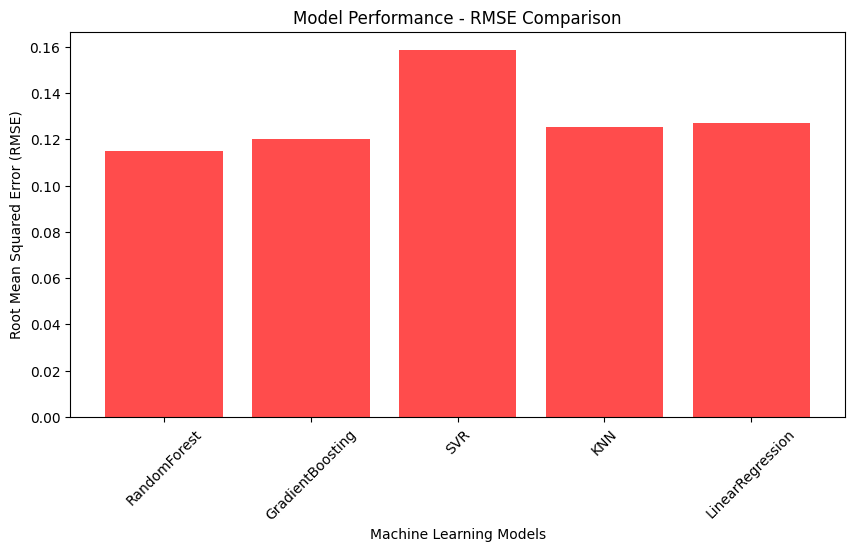

In [69]:
model_names = results_df["Model"]
mae_values = results_df["MAE"]
rmse_values = results_df["RMSE"]

# Plot MAE values
plt.figure(figsize=(10, 5))
plt.bar(model_names, mae_values, color='blue', alpha=0.7)
plt.xlabel("Machine Learning Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Performance - MAE Comparison")
plt.xticks(rotation=45)
plt.show()

# Plot RMSE values
plt.figure(figsize=(10, 5))
plt.bar(model_names, rmse_values, color='red', alpha=0.7)
plt.xlabel("Machine Learning Models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model Performance - RMSE Comparison")
plt.xticks(rotation=45)
plt.show()